# TITANIC 乘客生还率影响因素分析

> * 分析目的：通过kaggle上Titanic项目的训练集，探究‘ Titanic号上乘客生还率影响因素 ’，并进行进行描述性分析  
* 分析思路：先观察对乘客生还率可能造成影响的因素组成，再对各影响因素单独进行分析，观察影响情况，  
最后对各影响因素组合分析，分析各影响因素的影响程度，从而确定出影响乘客生还率的关键点




# 一. 数据预览

In [1]:
#导入分析和可视化主要库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#预设画布显示
% matplotlib inline
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.sans-serif'] =['SimHei']

In [3]:
#数据集内容为Titanic上的部分乘客相关数据
#读入数据集,先预览数据
ti=pd.read_csv('F:/titanic_dataset/train.csv',nrows=10)
print(ti)

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   
5            6         0       3   
6            7         0       1   
7            8         0       3   
8            9         1       3   
9           10         1       2   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   
5                                   Moran, Mr. James    male   NaN      0   
6                            McCarthy, Mr. Timothy J    male  54

In [4]:
#注意到其中PassengerId字段是按顺序排列的，可作为行索引
ti=pd.read_csv('F:/titanic_dataset/train.csv',index_col='PassengerId')
#概览数据
print(ti.shape)
ti.info()

(891, 11)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


可以看到，此数据集有891条记录  
所有字段及含义为：
> PassengerId：  乘客ID  
Survived：   是否生还，**0为否，1为是**   
Pclass：   乘客舱位等级&emsp;记为1，2，3三个等级  
Name：    乘客姓名  
Sex：    乘客性别&emsp;男性记为male，女性为female  
Age：    乘客年龄  
SibSp：   乘客在船上的兄弟姐妹及配偶人数  
Parch：   乘客在船上的父母及孩子人数  
Ticket：   乘客船票号码  
Fare：    乘客船票价格  
Cabin：   乘客船舱号码  
Embarked：   乘客登船港口&emsp;记为C,Q,S三地

其中，年龄值仅有714条，部分缺失，船舱号码仅204条，大量缺失，登船港口889条，缺失2条  

对于字段简要分析：  
> Survived是要考察的指标  
Pclass,Sex,Age,SibSp,Parch可能是相关性比较大的影响因素  
Name,Cabin,Embarked是相关性比较小的影响因素  
Ticket,Fare体现在Pclass,Cabin中

In [5]:
ti.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


从概览信息可以看出：  
* 乘客平均生还率仅38.38%
* 乘客平均年龄有29.70岁，最小的乘客0.42岁即4个月大，最大的乘客80岁
* 乘客平均票价仅32.20，而最高票价有512.33

# 二. 数据预处理

In [6]:
#检查重复项
ti.duplicated().value_counts()

False    891
dtype: int64

In [7]:
#检查是否缺失
ti.isnull().any()

Survived    False
Pclass      False
Name        False
Sex         False
Age          True
SibSp       False
Parch       False
Ticket      False
Fare        False
Cabin        True
Embarked     True
dtype: bool

In [8]:
#检查缺失项数目
ti.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

对于age项部分缺失，有以下几种填充方案：  
1. 用年龄平均数填充
2. 用年龄中位数填充
3. 不同性别以各性别的平均数分开填充年龄缺失值

In [9]:
ti['Age_case1']=ti['Age'].fillna(ti.Age.mean())    #以平均数填充
ti['Age_case2']=ti['Age'].fillna(ti.Age.median())  #以中位数填充

#各自以性别平均数来填充
ti['Age_case3']=ti.Age
age_groupby_sex=ti.groupby('Sex')['Age'].mean()
ti.loc[ti.Age_case3.isnull(),'Age_case3']=ti.loc[ti.Age_case3.isnull(),'Sex'].apply(lambda x:age_groupby_sex[x])

#不同方案填充完后年龄均值比较
ti[['Age','Age_case1','Age_case2','Age_case3']].mean()

Age          29.699118
Age_case1    29.699118
Age_case2    29.361582
Age_case3    29.736034
dtype: float64

可以看到，中位数填充的比均值填充的平均年龄偏小，以性别分开填充的方式与均值填充的相当

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002A28AE76748>,
      dtype=object)

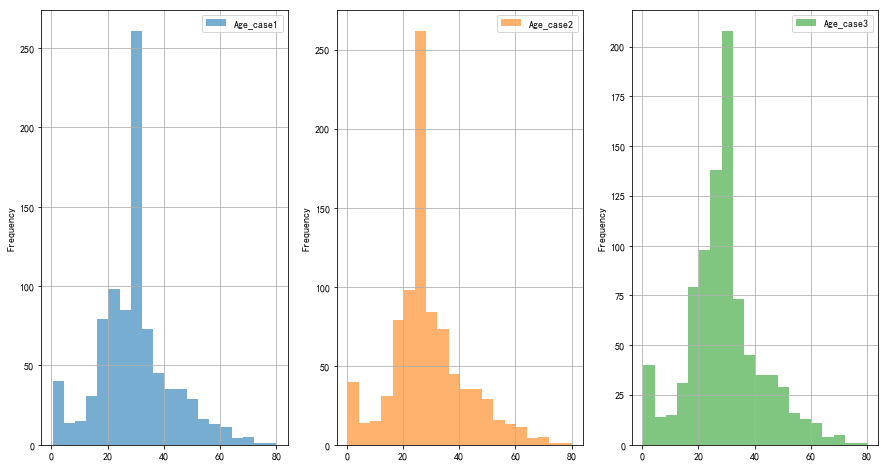

In [10]:
#通过直方图进行比较
ti[['Age_case1','Age_case2','Age_case3']].plot.hist(subplots=True,layout=(1,3),alpha=0.6,bins=20,grid=True)

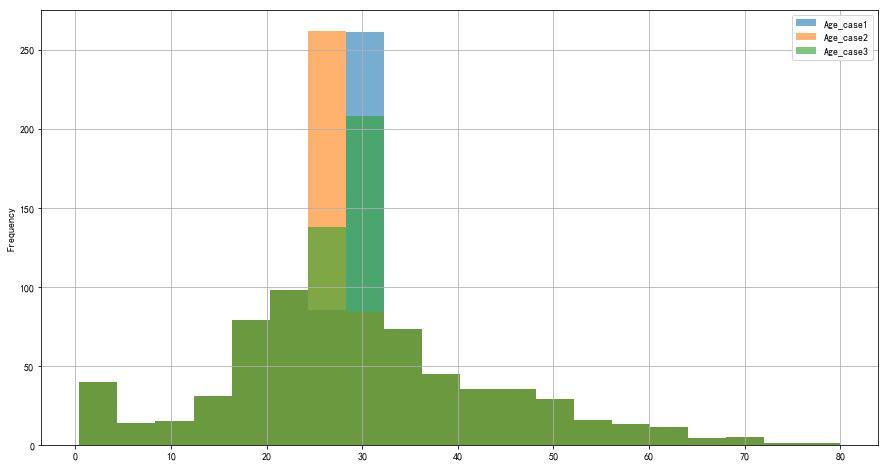

In [11]:
#画在同一张图上对比更明显
ti[['Age_case1','Age_case2','Age_case3']].plot.hist(alpha=0.6,bins=20,grid=True)

对比填充完后的情况，可以看出：  
    用均值填充后最高峰在30处，而中位数填充的在28-29处，而分性别填充的情况介于二者之间，参考意义更佳   
    故选用第三种方案填充年龄字段

In [12]:
ti['Age']=ti['Age_case3']
ti.drop(['Age_case1','Age_case2','Age_case3'],axis=1,inplace=True)

In [13]:
#处理embarked的缺失值，观察缺失项的其他信息
ti[ti.Embarked.isnull()].T

PassengerId,62,830
Survived,1,1
Pclass,1,1
Name,"Icard, Miss. Amelie","Stone, Mrs. George Nelson (Martha Evelyn)"
Sex,female,female
Age,38,62
SibSp,0,0
Parch,0,0
Ticket,113572,113572
Fare,80,80
Cabin,B28,B28


可以看到，两名乘客的船舱等级、船舱号码、船票号码、船票价格都一样，可以认为是同一地方登船

In [14]:
#再看不同等级舱位上船地点情况
ti[['Cabin','Pclass','Embarked']][(ti.Cabin.notnull()) & (ti.Pclass==3)]

,Cabin,Pclass,Embarked
PassengerId,,,
11,G6,3,S
76,F G73,3,S
129,F E69,3,C
206,G6,3,S
252,G6,3,S
395,G6,3,S
430,E10,3,S
700,F G63,3,S
716,F G73,3,S


In [15]:
ti[['Cabin','Pclass','Embarked']][(ti.Cabin.notnull()) & (ti.Pclass==2)]

,Cabin,Pclass,Embarked
PassengerId,,,
22,D56,2,S
67,F33,2,S
124,E101,2,S
149,F2,2,S
184,F4,2,S
194,F2,2,S
293,D,2,C
304,E101,2,Q
328,D,2,S


In [16]:
ti[['Cabin','Pclass','Embarked']][(ti.Cabin.notnull()) & (ti.Pclass==1)]

,Cabin,Pclass,Embarked
PassengerId,,,
2,C85,1,C
4,C123,1,S
7,E46,1,S
12,C103,1,S
24,A6,1,S
28,C23 C25 C27,1,S
32,B78,1,C
53,D33,1,C
55,B30,1,C


可以看出，按照英文字母顺序，船舱号码开头英文字母越往后的船舱等级越低，即A-C，D-E，F-G为多数一等，二等，三等舱位船舱

In [17]:
#根据船舱名称B开头的上船地点推断
cabin_b=ti['Cabin'].str.startswith('B')
ti[cabin_b==True][['Cabin','Embarked','Pclass']].sort_values(by='Cabin')

,Cabin,Embarked,Pclass
PassengerId,,,
738,B101,C,1
816,B102,S,1
524,B18,C,1
330,B18,C,1
171,B19,S,1
691,B20,S,1
782,B20,S,1
541,B22,S,1
746,B22,S,1


In [18]:
ti['Embarked'][cabin_b==True].value_counts()

S    23
C    22
Name: Embarked, dtype: int64

可见B开头船舱号码上船地点在C和S两地，但数量相当，还需进一步判断

Text(0.5, 1.0, '不同船舱等级、登船港口的船票价格分布')

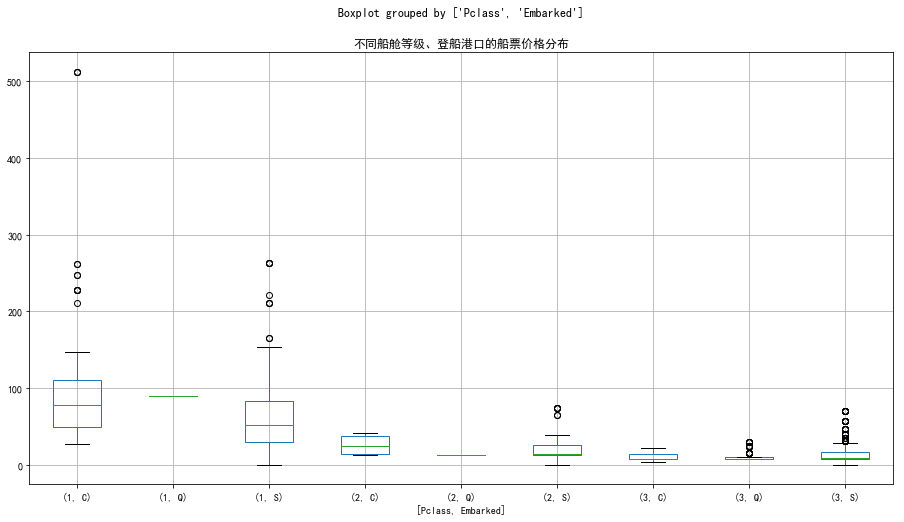

In [19]:
#考虑用船票价格分布来推断可能上船地点，使用箱线图表征
ti.boxplot(column='Fare',by=['Pclass','Embarked'])
plt.title('不同船舱等级、登船港口的船票价格分布')

可以看出，一等舱在C地登船大的平均票价明显比S地登船要高，更接近100，而缺失记录的票价为80  
故而大概率是C地登船

In [20]:
ti['Embarked'].fillna('C',inplace=True)
ti['Embarked'].isnull().value_counts()

False    891
Name: Embarked, dtype: int64

In [21]:
#cabin项缺失较多，难以填充，可删除
ti.drop(['Cabin'],axis=1,inplace=True)

In [22]:
#SibSp,Parchz字段表示乘客同行的家人和亲友数，可合成后来观察
ti['Together']=ti['SibSp']+ti['Parch']

In [23]:
#最后删除相关性小且难以分析的字段，Name,Ticket
ti.drop(['Name','Ticket'],axis=1,inplace=True)
ti.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Together
PassengerId,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S,1
2,1,1,female,38.0,1,0,71.2833,C,1
3,1,3,female,26.0,0,0,7.9250,S,0
4,1,1,female,35.0,1,0,53.1000,S,1
5,0,3,male,35.0,0,0,8.0500,S,0


# 三. 数据分析

## 1. 变量组成分析

In [24]:
#定义画图函数，分析各字段内部组成
def base_plot(col,title):
    ax1=plt.subplot2grid(shape=(1,2),loc=(0,0))
    ax2=plt.subplot2grid(shape=(1,2),loc=(0,1))
    col.value_counts().plot.bar(ax=ax1,legend=True,grid=True)
    ax1.set_title('%s数量分布情况'%title)
    col.value_counts().plot.pie(ax=ax2,autopct='%.2f%%',startangle=90,legend=True)
    ax2.set_title('%s数量分布占比'%title)

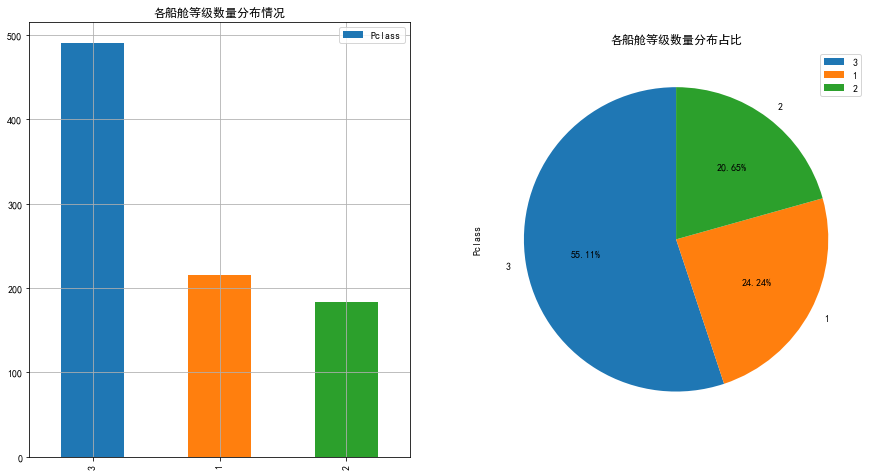

In [25]:
base_plot(ti.Pclass,'各船舱等级')

可以看到，三等船舱的乘客最多，占比达到了55.11%，二等舱和一等舱的乘客数相当

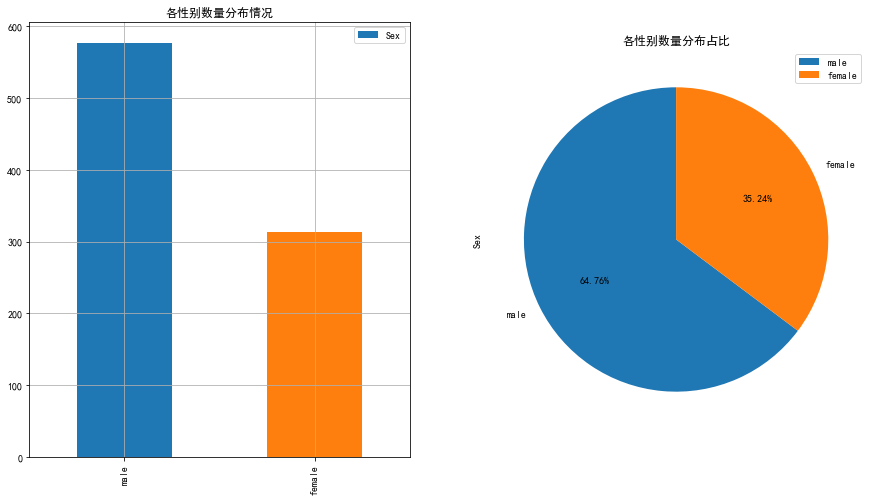

In [26]:
base_plot(ti.Sex,'各性别')

可以看到，乘客中男性明显多于女性，男性乘客占比64.76%，约为女性乘客的两倍

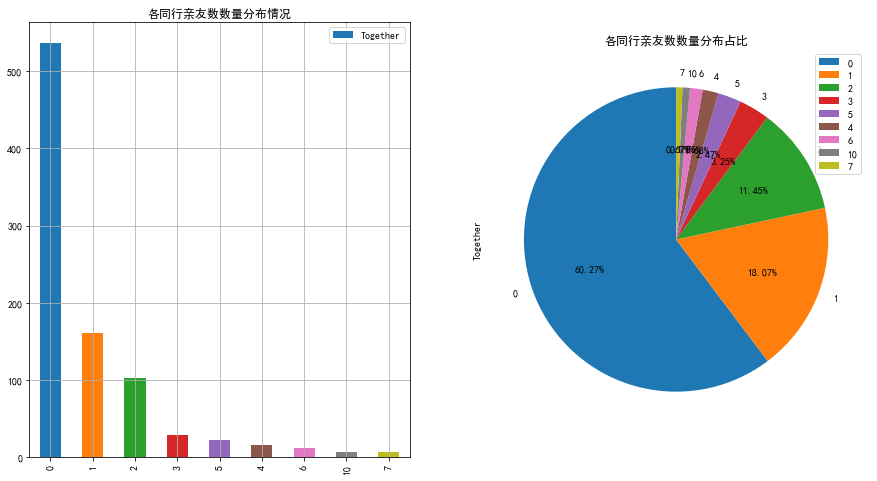

In [27]:
base_plot(ti.Together,'各同行亲友数')

可以看到，独自出行的乘客人数要比亲友同行的乘客多，独自出行的乘客占比达到了60.27%  
亲友同行的乘客中，同行人数为2个以内的人数最多，3个以上的很少

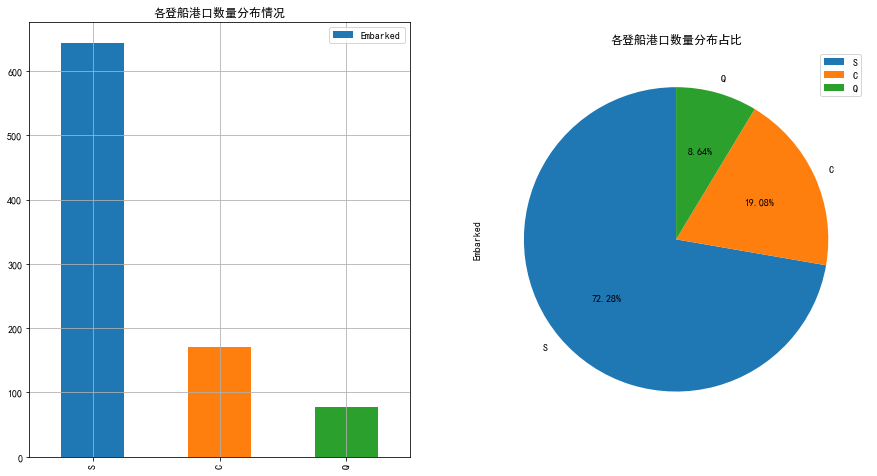

In [28]:
base_plot(ti.Embarked,'各登船港口')

可以看到，大多数乘客都是从S地登船，占比达到了72.44%，C地登船和Q地登船的乘客分别只占了18.09%和8.66%

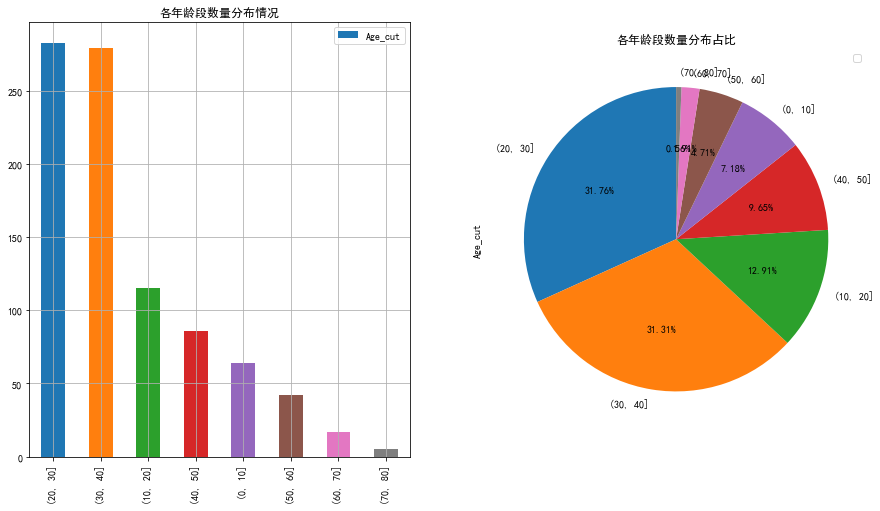

In [29]:
#对于连续的字段，如Age，Fare，先分箱再画图
ti['Age_cut']=pd.cut(ti.Age,bins=range(0,81,10))
base_plot(ti.Age_cut,'各年龄段')
plt.legend(())

可以看到，20-30年龄段的乘客最多，占比有32.21%，其次是30-40年龄段，占比有21.71%，接着是10-20年龄段，占比有16.11%  
即乘客中10-40年龄段的人数占绝大部分

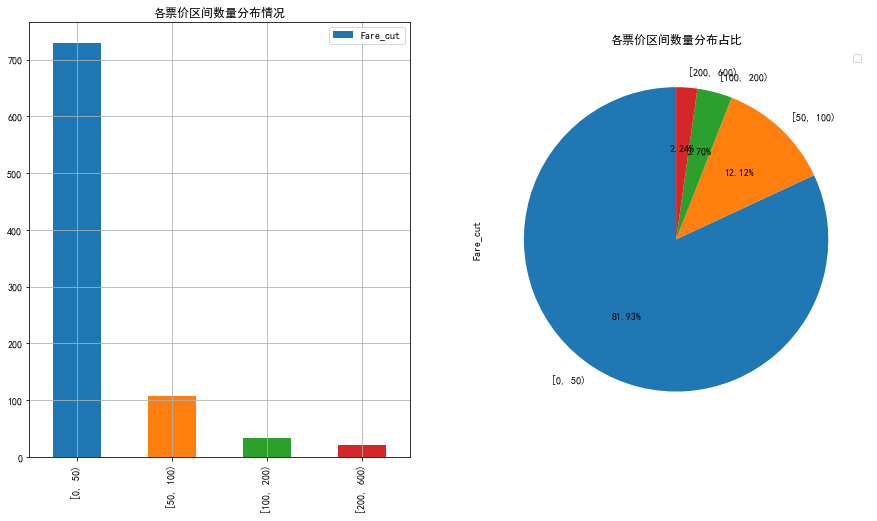

In [30]:
ti['Fare_cut']=pd.cut(ti.Fare,bins=[0,50,100,200,600],right=False)
base_plot(ti.Fare_cut,'各票价区间')
plt.legend(())

可以看到，票价在50以下的乘客占绝大多数，占比达到81.93%

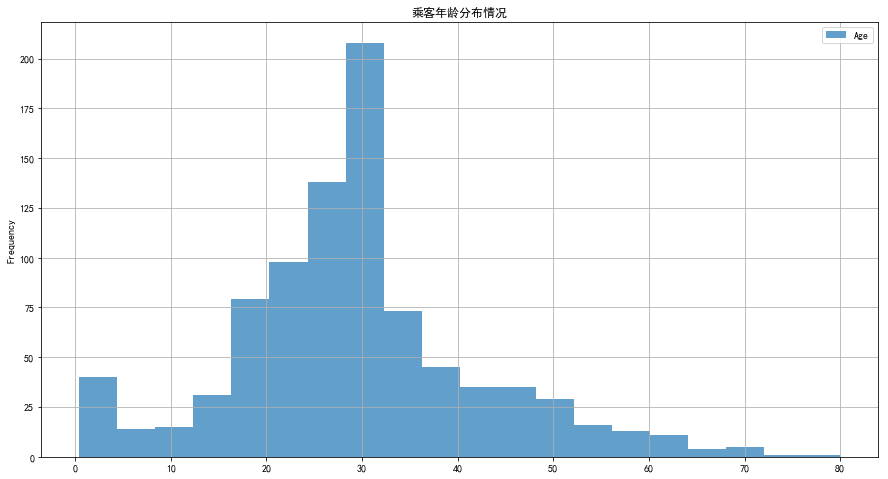

In [31]:
#也可用直方图表示年龄及票价分布
ti[['Age']].plot.hist(grid=True,bins=20,alpha=0.7,title='乘客年龄分布情况')

可以看出，乘客年龄在10-50的占了绝大多数

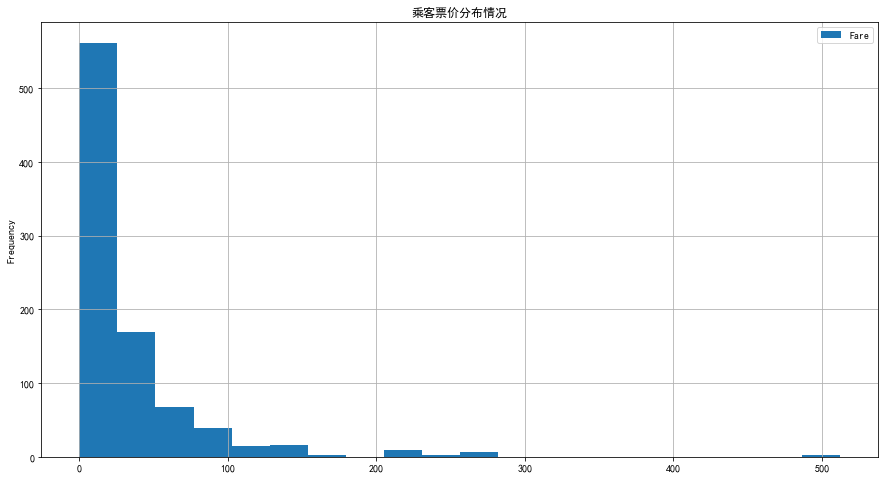

In [32]:
ti[['Fare']].plot.hist(grid=True,bins=20,title='乘客票价分布情况')

可以看出，乘客票价多在50以下，票价100以内的乘客占了绝大多数，票价100以上的乘客寥寥无几，但有个别乘客票价达到了500

## 2. 单变量分析

In [33]:
#定义画图函数，分析单个字段对指标的影响
def one_plot(col,title):
    ax1=plt.subplot2grid(shape=(1,2),loc=(0,0))
    ax2=plt.subplot2grid(shape=(1,2),loc=(0,1))
    ti.groupby([col,'Survived'])['Survived'].count().unstack().plot.bar(ax=ax1,legend=True,grid=True)
    ax1.set_title('%s生还情况对比'%title)
    ti.groupby(col)['Survived'].mean().plot.bar(ax=ax2,legend=True,grid=True)
    ax2.set_title('%s生还率对比'%title)

([<matplotlib.axis.YTick at 0x2a28ccc1358>,
 <a list of 10 Text yticklabel objects>)

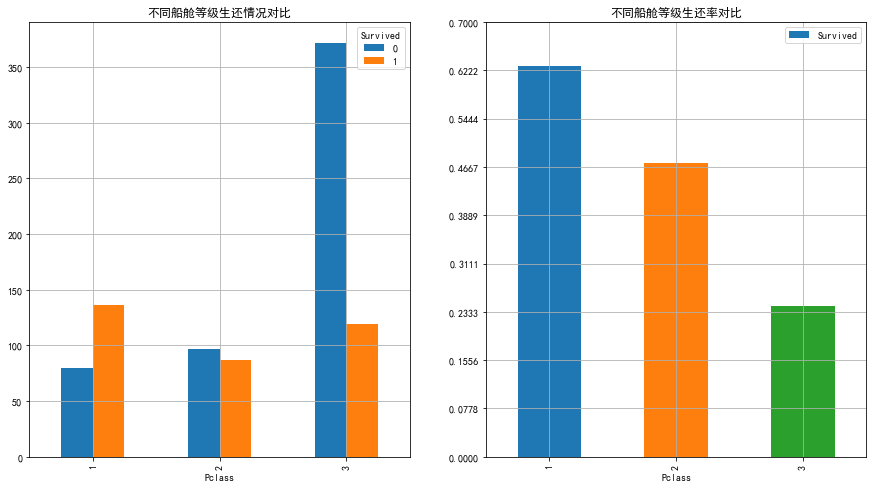

In [34]:
one_plot('Pclass','不同船舱等级')
plt.yticks(np.linspace(0,0.7,10,endpoint=True))

可以看到，乘客船舱等级对生还率影响明显，船舱等级越高，乘客生还率越高  
其中，一等舱的生还率最高，略超过62.2%，二等舱约46.7%，三等舱则仅有约23.3%  
而三等舱人数最多，多数未生还，未生还人数超过350人

([<matplotlib.axis.YTick at 0x2a28cd99e48>,
 <a list of 10 Text yticklabel objects>)

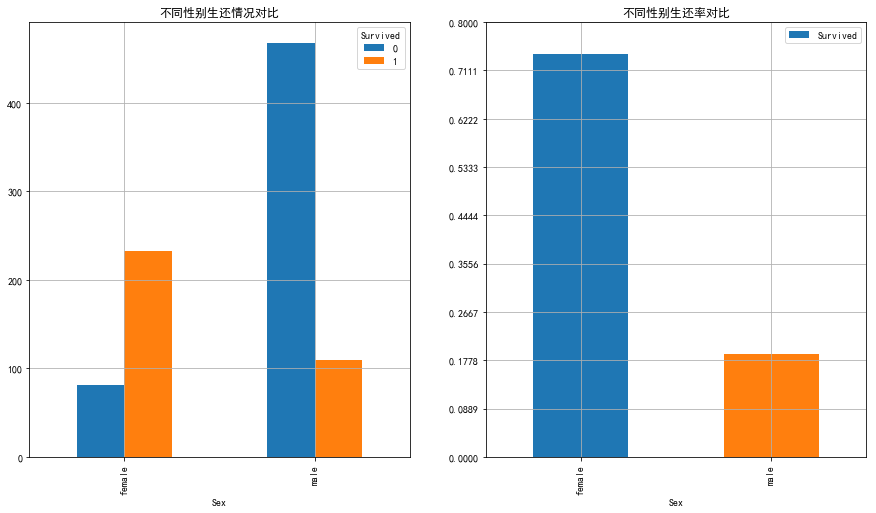

In [35]:
one_plot('Sex','不同性别')
plt.yticks(np.linspace(0,0.8,10,endpoint=True))

可以看到，乘客性别对生还率影响明显，女性乘客生还率大大高于男性  
女性生还率略超过71.1%，而男性生还率则仅有约17.8%  
未生还人数上，女性未生还人数不到100人，而男性未生还人数超过400人

([<matplotlib.axis.YTick at 0x2a28ce6c160>,
 <a list of 20 Text yticklabel objects>)

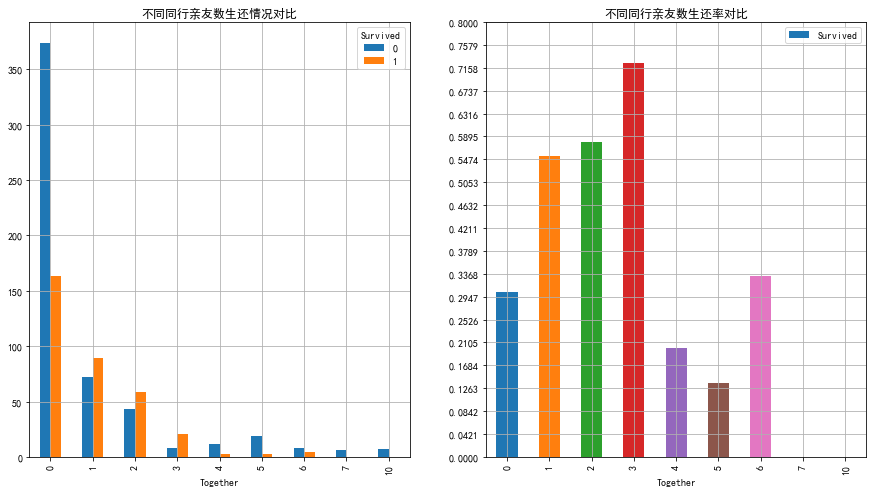

In [36]:
one_plot('Together','不同同行亲友数')
plt.yticks(np.linspace(0,0.8,20,endpoint=True))

可以看到，亲友同行人数对生还率也有一定影响，亲友同行人数为3个的乘客生还率最高，其次是2个和1个，生还率分别约71.6%，58.9% ，54.7%  
而独自出行的乘客生还率仅有约29.5%  
亲友同行3个以上的乘客生还率明显下降  
但因为亲友同行人数3个或3个以上的人数较少，参考性有限  
着重考虑亲友同行人数为1或2个时，可以认为，有同行亲友的乘客生还率普遍高于独自出行的乘客  
未生还人数上，亲友同行的乘客未生还人数均少于100人，而独自出行的乘客未生还人数超过350人  
可以合理解释：有亲友同行在这种情况下能得到更多的帮助，但亲友数太多，可能导致因救援资源不足部分亲友主动放弃生还机会

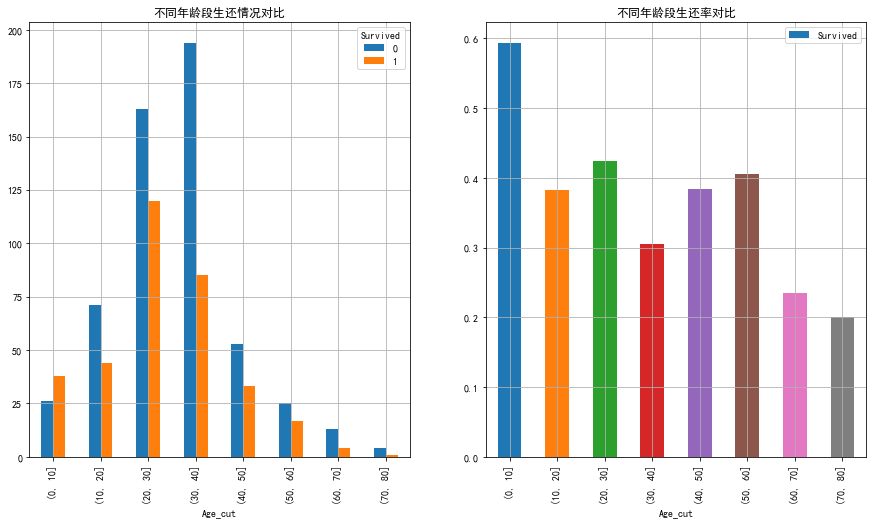

In [37]:
one_plot('Age_cut','不同年龄段')

可以看到，年龄对乘客生还率也有一定影响，其中，年龄在0-10的乘客生还率最高，达到约60%  
60-80年龄段生还率较低，除了这两个年龄段，其余年龄段生还率相差不大，都在40%上下  
20-30年龄段的未生还人数最多，超过140人  
可以合理解释：年龄小的婴儿，儿童优先救援，而年长一辈可能将生还机会让给年轻一辈的

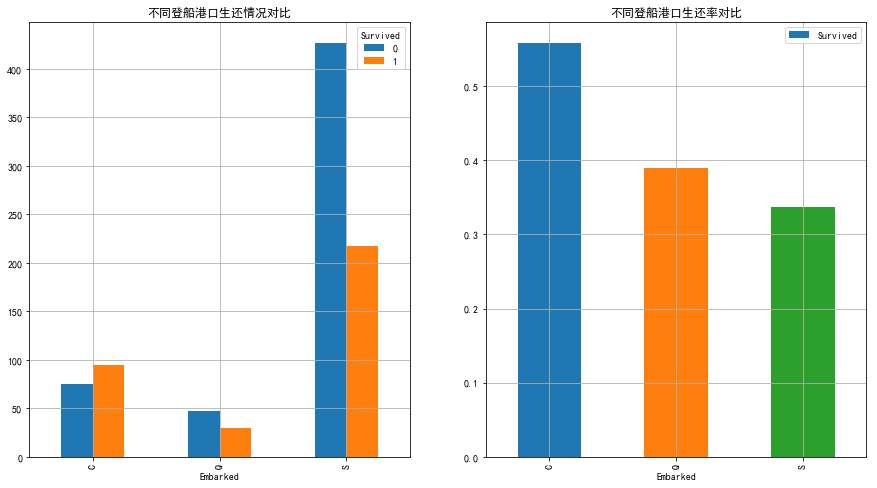

In [38]:
one_plot('Embarked','不同登船港口')

可以看到，S地登船的乘客人数最多，C/Q登船的人数较少，生还率上来看有所差距，但由于人数不均，参考意义较小

## 3. 双变量分析

In [39]:
#ti.groupby(['Pclass','Sex','Survived'])['Survived'].count().unstack([-2,-1]).plot.bar(legend=True,grid=True)
#定义画图函数，分析两个字段对指标的共同影响及影响程度
def two_plot(col1,col2,title1,title2):
 
    fig,[[ax1,ax2],[ax3,ax4]]=plt.subplots(nrows=2,ncols=2)
    pd.crosstab([ti['%s'%col1],ti['%s'%col2]],[ti.Survived]).plot.barh(ax=ax1,stacked=True,grid=True)
    pd.crosstab([ti['%s'%col2],ti['%s'%col1]],[ti.Survived]).plot.barh(ax=ax2,stacked=True,grid=True)
    ax1.set_title('不同%s、%s下的生还情况对比'%(title1,title2))
    ax2.set_title('不同%s、%s下的生还情况对比'%(title1,title2))
    
    ti.pivot_table(values='Survived',index=col1,columns=col2,aggfunc='mean').plot.bar(ax=ax3,grid=True)
    ti.pivot_table(values='Survived',index=ti['%s'%col2],columns=ti['%s'%col1],aggfunc='mean').plot.bar(ax=ax4,grid=True)
    ax3.set_title('不同%s、%s下的生还率对比'%(title1,title2))
    ax4.set_title('不同%s、%s下的生还率对比'%(title1,title2))
    

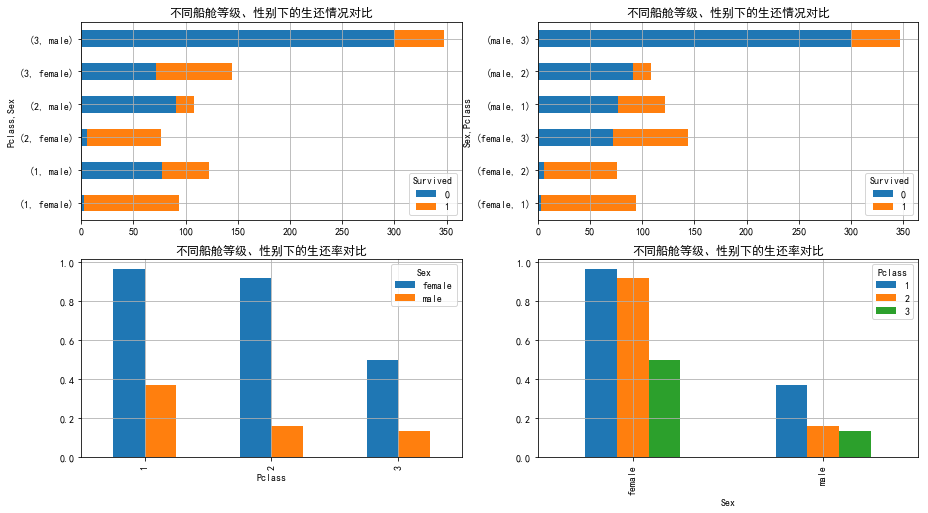

In [40]:
#先探究乘客船舱等级与性别对生还率的影响
two_plot('Pclass','Sex','船舱等级','性别')

可以看到，不论是哪个船舱等级，女性的生还率都远远高于男性  
而同一性别时，船舱等级越高生还率也越高  
一等舱和二等舱的女性生还率超过80%，二等舱和三等舱的男性生还率却低于20%  
三等舱的男性未生还人数最多，约有300人，一等舱及二等舱的女性绝大多数生还  
**因此认为：乘客性别对生还率的影响明显大于乘客的船舱等级**

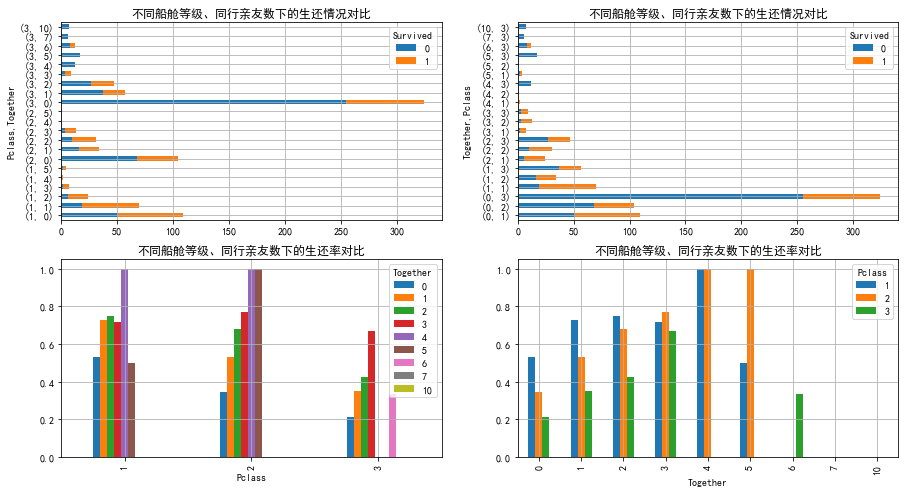

In [41]:
#探究船舱等级与同行亲友数对生还率的影响
two_plot('Pclass','Together','船舱等级','同行亲友数')

可以看到，无论是否有亲友同行，一等舱或二等舱的乘客生还率明显高于三等舱  
而同一船舱，有亲友同行的乘客生还率普遍高于独自出行的  
未生还人数上，三等舱独自出行的乘客未生还人数最多，超过250人，其次是二等舱独自出行的乘客，超过50人  
**因此认为：乘客船舱等级对生还率的影响明显大于乘客的同行亲友数**

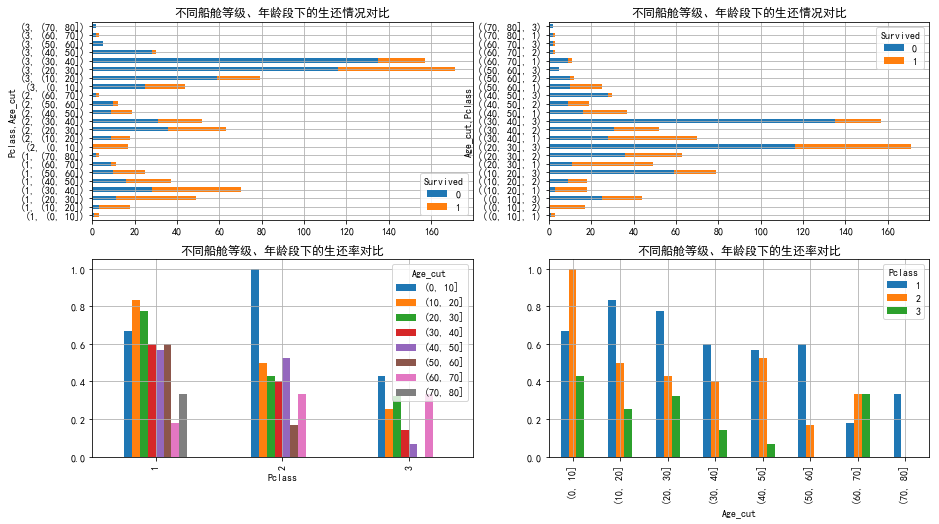

In [42]:
#探究船舱等级与年龄段对生还率的影响
two_plot('Pclass','Age_cut','船舱等级','年龄段')

可以看到，除了特殊年龄段0-10，其他年龄段上，船舱等级越高乘客生还率普遍越高  
而同一船舱，除了特殊年龄段0-10，其他年龄段乘客的生还率相当   
三等舱20-40年龄段的乘客未生还人数最多  
**因此认为：特殊年龄段0-10以外，乘客船舱等级对生还率的影响明显大于乘客的年龄段**

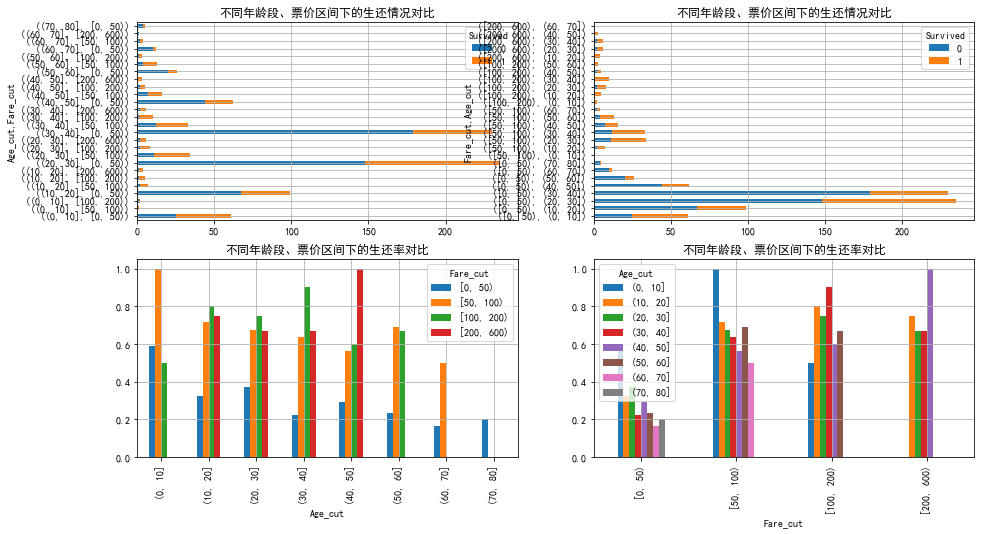

In [43]:
#探究票价区间与年龄段对生还率的影响
two_plot('Age_cut','Fare_cut','年龄段','票价区间')

(0, 300)

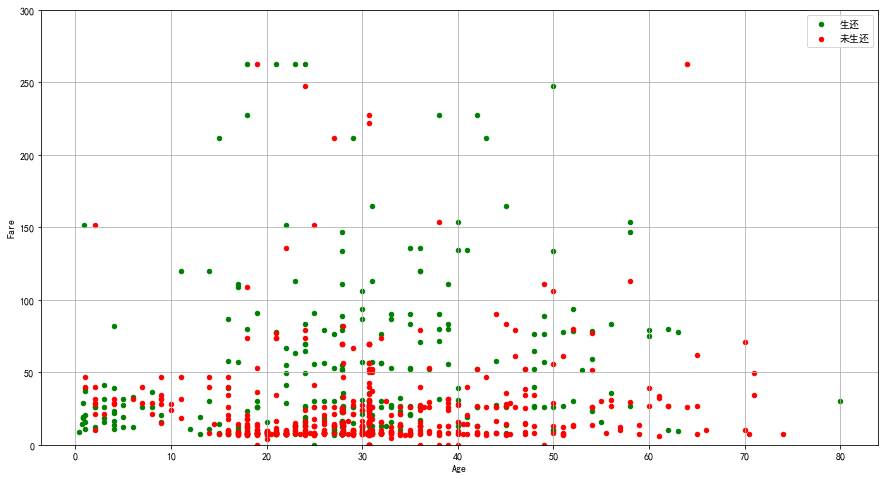

In [44]:
#图示分组太多，不够清晰，换用散点图
fig,ax=plt.subplots()
ti[ti.Survived==1].plot.scatter('Age','Fare',ax=ax,c='g',grid=True,label='生还')
ti[ti.Survived==0].plot.scatter('Age','Fare',ax=ax,c='r',grid=True,label='未生还')
ax.set_ylim(0,300)

可以看出，生还乘客上，除了年龄段在0-10的生还乘客有集中现象，其余生还乘客分布较为分散  
而未生还乘客明显集中在票价低的乘客上，靠近于图示底部集中  
**因此认为：特殊年龄段0-10以外，票价区间对生还率的影响明显大于乘客的年龄段  
因为票价区间直接关联到船舱等级，侧面体现了船舱等级的影响**

# 四. 结论和改进建议

## 1. 结论

> Titanic号上乘客的生还率影响因素有：性别，船舱等级，年龄，同行亲友数，票价  
其中：  
* 性别优先级最高，影响程度最大，女性的生还率远高于男性
* 船舱等级影响程度次之，船舱等级越高，生还率越高
* 0-10年龄段的乘客生还率高，其余年龄段相当，表现不明显
* 同行亲友数对乘客生还率也有影响，同行亲友数为1或2个的乘客，生还率要明显高于独自出行的乘客

> 可以结合实际情况解释：根据相关报导，Titanic失事后，船长等人指示妇女和小孩先走，而乘客也很好地遵守

## 2. 改进建议

> * 因年龄缺失值较多，所用均值填充的办法会使年龄集中于均值，影响后续的分析准确度，可考虑其他填充方式
* 对Name，Ticket，Cabin等字段，直接分析较难，但可结合相关历史资料，进行辅助分析 
* 所用数据集仅为训练集，只占总乘客数的1/3，叠加上测试集能使结果更为准确
* 可考虑使用机器学习的相关算法做预测，进一步佐证描述性分析